In [1]:
%%capture
#!pip install wfdb
BASEPATH = '..'
import sys
sys.path.insert(0,'../py')
print(sys.path)
import numpy as np
import tensorflow as tf
from utils import reset_seed, plot_spectogram, plot_loss
from utils import integer_mapping, mapping_AAMI, MAP_AAMI, INT_MAP_DICT
from data_handling import DataHandling
from data_preprocessing import DataPreprocessing
from report import Reports
from models.model_with_one_mhb import MultiHeadAttentionClassifier 


reset_seed()

In [2]:
#!rm -r sample_data

#Load & Preprocess data

In [3]:
%%script false

#load-split data
dh = DataHandling(base_path = BASEPATH)

load_file1=True
if load_file1:
  x_ttv, y_ttv = dh.loadData(file_path= BASEPATH + 'dataset_splitted.dat')
  [x_train,x_test,x_val] = x_ttv 
  [y_train,y_test,y_val] = y_ttv
else:
  xds,yds=dh.loadData(file_path= BASEPATH + 'dataset.dat')

  X= xds
  y = yds
  from sklearn.model_selection import train_test_split
  x_train, x_val, y_train, y_val  = train_test_split(X, y,test_size=0.20,stratify = y, random_state=142, shuffle=True)
  x_train, x_test, y_train, y_test  = train_test_split(x_train, y_train,test_size=0.25,stratify = y_train, random_state=142, shuffle=True)
  ####fix for minority class S
  '''
  _,indexes = dh.searchType(x_train,y_train,Numb=0,sym='S')
  index = indexes[0]
  x_test = np.append(x_test, x_train[index][np.newaxis,:], axis=0)
  y_test.append(y_train[index])
  x_train = np.delete(x_train, index, axis=0)
  y_train = np.delete(y_train, index)
  '''
  #####

  x_ttv = [x_train,x_test,x_val]
  y_ttv = [y_train,y_test,y_val]
  dh.saveData(x_ttv,y_ttv, file_path='dataset_splitted.dat')

dh.reportStats(xds,yds) = 
{'/': 3619,
 'A': 2546,
 'E': 106,
 'F': 802,
 'J': 83,
 'L': 8071,
 'N': 74759,
 'Q': 15,
 'R': 7256,
 'S': 2,
 'V': 7123,
 'a': 150,
 'e': 16,
 'f': 260,
 'j': 229}

In [4]:
#Preprocessing
dh = DataHandling(base_path=BASEPATH)

load_file=True
if load_file:
  xds_features_ttv, yds_ttv = dh.loadData(file_path= BASEPATH + 'Feat_spect_splitted.dat')
  [xds_features_train,xds_features_test,xds_features_val] = xds_features_ttv 
  [y_train,y_test,y_val] = yds_ttv 
else:
  #preprocess data
  dpr = DataPreprocessing()
  xds_features_train = dpr.specgram(x_train, Fs=360, nperseg=127, noverlap=122)
  xds_features_test = dpr.specgram(x_test, Fs=360, nperseg=127, noverlap=122)
  xds_features_val = dpr.specgram(x_val, Fs=360, nperseg=127, noverlap=122)

  xds_features_ttv = [xds_features_train, xds_features_test, xds_features_val]
  yds_ttv = [y_train,y_test,y_val]
  dh.saveData(xds_features_ttv, yds_ttv, file_path='Feat_spect_splitted.dat')

x_train = xds_features_train
x_test = xds_features_test
x_val = xds_features_val

In [5]:
x_train.shape, x_test.shape, x_val.shape, len(y_train), len(y_test), len(y_val)

((63021, 26, 64), (21008, 26, 64), (21008, 26, 64), 63021, 21008, 21008)

In [6]:
dh.reportStats(x_train,y_train)

{'/': 2171,
 'A': 1528,
 'E': 64,
 'F': 481,
 'J': 49,
 'L': 4843,
 'N': 44855,
 'Q': 9,
 'R': 4354,
 'S': 1,
 'V': 4273,
 'a': 90,
 'e': 10,
 'f': 156,
 'j': 137}

In [7]:
dh.reportStats(x_test,y_test)

{'/': 724,
 'A': 509,
 'E': 21,
 'F': 160,
 'J': 17,
 'L': 1614,
 'N': 14952,
 'Q': 3,
 'R': 1451,
 'S': 1,
 'V': 1425,
 'a': 30,
 'e': 3,
 'f': 52,
 'j': 46}

In [8]:
dh.reportStats(x_val,y_val)

{'/': 724,
 'A': 509,
 'E': 21,
 'F': 161,
 'J': 17,
 'L': 1614,
 'N': 14952,
 'Q': 3,
 'R': 1451,
 'S': 0,
 'V': 1425,
 'a': 30,
 'e': 3,
 'f': 52,
 'j': 46}

In [9]:
y_train = integerMapping(y_train,intMapDict)
#y_test = integerMapping(y_train,intMapDict)
y_val = integerMapping(y_val,intMapDict)

#Train

In [ ]:
params = {
    'seq_len' : x_train.shape[-2],
    'd_model' : x_train.shape[-1],
    'num_heads' : 2,
    'num_classes' : 15,
    'drate' : 0.15,
    'batch_size' : 128,
    'epochs' : 100
}
print(params)

{'seq_len': 26, 'd_model': 64, 'num_heads': 2, 'num_classes': 15, 'drate': 0.15, 'batch_size': 128, 'epochs': 100}


In [ ]:
model_classifier  = MultiHeadAttentionClassifier(
                                            seq_len=params['seq_len'],
                                            d_model = params['d_model'],
                                            num_heads = params['num_heads'],
                                            num_classes=params['num_classes'],
                                            drate=params['drate']
                                                  )

In [ ]:
!rm -r /content/drive/MyDrive/ecARR/checkpoint/keras.modelM1_ab2

opt= tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Adam'
)

#for loss try sample_weight
model_classifier.compile(
                      optimizer=opt,
                      loss="sparse_categorical_crossentropy",
                      metrics=['accuracy'],
                      loss_weights=None
                      )


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5,
                              verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0.0001)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(BASEPATH + "checkpoint/keras.modelM1_ab2",
                                                      monitor='val_loss', save_best_only=True, verbose=1)

callbacks = [early_stopping, model_checkpoint, reduce_lr]

model_history = model_classifier.fit(
              x=x_train,
              y=y_train,
              batch_size=params['batch_size'],
              epochs=params['epochs'],
              verbose=1,
              callbacks=callbacks,
              validation_data=(x_val, y_val),
              shuffle=True,
              class_weight=None,
              sample_weight=None,
              initial_epoch=0
              )

rm: cannot remove '/content/drive/MyDrive/ecARR/checkpoint/keras.modelM1_ab2': No such file or directory
Epoch 1/100
493/493 [==============================] - 25s 46ms/step - loss: 0.3513 - accuracy: 0.9078 - val_loss: 0.1890 - val_accuracy: 0.9514

Epoch 00001: val_loss improved from inf to 0.18896, saving model to /content/drive/MyDrive/ecARR/checkpoint/keras.modelM1_ab2


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ecARR/checkpoint/keras.modelM1_ab2/assets


Epoch 2/100
493/493 [==============================] - 18s 36ms/step - loss: 0.1798 - accuracy: 0.9544 - val_loss: 0.1554 - val_accuracy: 0.9604



Epoch 00002: val_loss improved from 0.18896 to 0.15543, saving model to /content/drive/MyDrive/ecARR/checkpoint/keras.modelM1_ab2


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ecARR/checkpoint/keras.modelM1_ab2/assets


Epoch 3/100
493/493 [==============================] - 19s 39ms/step - loss: 0.1467 - accuracy: 0.9613 - val_loss: 0.1277 - val_accuracy: 0.9674



Epoch 00003: val_loss improved from 0.15543 to 0.12770, saving model to /content/drive/MyDrive/ecARR/checkpoint/keras.modelM1_ab2


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ecARR/checkpoint/keras.modelM1_ab2/assets


Epoch 4/100
493/493 [==============================] - 19s 38ms/step - loss: 0.1309 - accuracy: 0.9649 - val_loss: 0.1020 - val_accuracy: 0.9716



Epoch 00004: val_loss improved from 0.12770 to 0.10197, saving model to /content/drive/MyDrive/ecARR/checkpoint/keras.modelM1_ab2


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ecARR/checkpoint/keras.modelM1_ab2/assets


Epoch 5/100
493/493 [==============================] - 19s 38ms/step - loss: 0.1200 - accuracy: 0.9678 - val_loss: 0.0982 - val_accuracy: 0.9731



Epoch 00005: val_loss improved from 0.10197 to 0.09819, saving model to /content/drive/MyDrive/ecARR/checkpoint/keras.modelM1_ab2


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ecARR/checkpoint/keras.modelM1_ab2/assets


Epoch 6/100
493/493 [==============================] - 18s 36ms/step - loss: 0.1129 - accuracy: 0.9693 - val_loss: 0.0942 - val_accuracy: 0.9747



Epoch 00006: val_loss improved from 0.09819 to 0.09416, saving model to /content/drive/MyDrive/ecARR/checkpoint/keras.modelM1_ab2


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ecARR/checkpoint/keras.modelM1_ab2/assets


Epoch 7/100
493/493 [==============================] - 19s 38ms/step - loss: 0.1055 - accuracy: 0.9705 - val_loss: 0.0865 - val_accuracy: 0.9766



Epoch 00007: val_loss improved from 0.09416 to 0.08645, saving model to /content/drive/MyDrive/ecARR/checkpoint/keras.modelM1_ab2


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ecARR/checkpoint/keras.modelM1_ab2/assets


Epoch 8/100
493/493 [==============================] - 19s 38ms/step - loss: 0.0973 - accuracy: 0.9738 - val_loss: 0.0865 - val_accuracy: 0.9769

Epoch 00008: val_loss did not improve from 0.08645
Epoch 9/100
493/493 [==============================] - 18s 37ms/step - loss: 0.0963 - accuracy: 0.9736 - val_loss: 0.0851 - val_accuracy: 0.9772



Epoch 00009: val_loss improved from 0.08645 to 0.08512, saving model to /content/drive/MyDrive/ecARR/checkpoint/keras.modelM1_ab2


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ecARR/checkpoint/keras.modelM1_ab2/assets


Epoch 10/100
493/493 [==============================] - 18s 37ms/step - loss: 0.0903 - accuracy: 0.9749 - val_loss: 0.0821 - val_accuracy: 0.9770



Epoch 00010: val_loss improved from 0.08512 to 0.08209, saving model to /content/drive/MyDrive/ecARR/checkpoint/keras.modelM1_ab2


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ecARR/checkpoint/keras.modelM1_ab2/assets


Epoch 11/100
493/493 [==============================] - 18s 37ms/step - loss: 0.0883 - accuracy: 0.9753 - val_loss: 0.0858 - val_accuracy: 0.9776

Epoch 00011: val_loss did not improve from 0.08209
Epoch 12/100
493/493 [==============================] - 18s 37ms/step - loss: 0.0835 - accuracy: 0.9768 - val_loss: 0.0750 - val_accuracy: 0.9793



Epoch 00012: val_loss improved from 0.08209 to 0.07498, saving model to /content/drive/MyDrive/ecARR/checkpoint/keras.modelM1_ab2


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ecARR/checkpoint/keras.modelM1_ab2/assets


Epoch 13/100
493/493 [==============================] - 18s 37ms/step - loss: 0.0816 - accuracy: 0.9775 - val_loss: 0.0746 - val_accuracy: 0.9804

Epoch 00013: val_loss improved from 0.07498 to 0.07457, saving model to /content/drive/MyDrive/ecARR/checkpoint/keras.modelM1_ab2


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ecARR/checkpoint/keras.modelM1_ab2/assets


Epoch 14/100
493/493 [==============================] - 18s 37ms/step - loss: 0.0782 - accuracy: 0.9782 - val_loss: 0.0769 - val_accuracy: 0.9800

Epoch 00014: val_loss did not improve from 0.07457
Epoch 15/100
493/493 [==============================] - 18s 37ms/step - loss: 0.0745 - accuracy: 0.9790 - val_loss: 0.0722 - val_accuracy: 0.9806



Epoch 00015: val_loss improved from 0.07457 to 0.07216, saving model to /content/drive/MyDrive/ecARR/checkpoint/keras.modelM1_ab2


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ecARR/checkpoint/keras.modelM1_ab2/assets


Epoch 16/100
493/493 [==============================] - 18s 37ms/step - loss: 0.0728 - accuracy: 0.9793 - val_loss: 0.0675 - val_accuracy: 0.9815



Epoch 00016: val_loss improved from 0.07216 to 0.06747, saving model to /content/drive/MyDrive/ecARR/checkpoint/keras.modelM1_ab2


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ecARR/checkpoint/keras.modelM1_ab2/assets


Epoch 17/100
493/493 [==============================] - 18s 37ms/step - loss: 0.0699 - accuracy: 0.9801 - val_loss: 0.0737 - val_accuracy: 0.9796

Epoch 00017: val_loss did not improve from 0.06747
Epoch 18/100
493/493 [==============================] - 18s 37ms/step - loss: 0.0703 - accuracy: 0.9803 - val_loss: 0.0700 - val_accuracy: 0.9810

Epoch 00018: val_loss did not improve from 0.06747
Epoch 19/100
493/493 [==============================] - 18s 37ms/step - loss: 0.0672 - accuracy: 0.9808 - val_loss: 0.0724 - val_accuracy: 0.9810

Epoch 00019: val_loss did not improve from 0.06747
Epoch 20/100
493/493 [==============================] - 18s 37ms/step - loss: 0.0644 - accuracy: 0.9814 - val_loss: 0.0769 - val_accuracy: 0.9810

Epoch 00020: val_loss did not improve from 0.06747
Epoch 21/100
493/493 [==============================] - 18s 37ms/step - loss: 0.0653 - accuracy: 0.9814 - val_loss: 0.0666 - val_accuracy: 0.9821



Epoch 00021: val_loss improved from 0.06747 to 0.06663, saving model to /content/drive/MyDrive/ecARR/checkpoint/keras.modelM1_ab2


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ecARR/checkpoint/keras.modelM1_ab2/assets


Epoch 22/100
493/493 [==============================] - 18s 37ms/step - loss: 0.0633 - accuracy: 0.9824 - val_loss: 0.0643 - val_accuracy: 0.9828



Epoch 00022: val_loss improved from 0.06663 to 0.06431, saving model to /content/drive/MyDrive/ecARR/checkpoint/keras.modelM1_ab2


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ecARR/checkpoint/keras.modelM1_ab2/assets


Epoch 23/100
493/493 [==============================] - 18s 37ms/step - loss: 0.0618 - accuracy: 0.9817 - val_loss: 0.0670 - val_accuracy: 0.9820

Epoch 00023: val_loss did not improve from 0.06431
Epoch 24/100
493/493 [==============================] - 18s 37ms/step - loss: 0.0597 - accuracy: 0.9823 - val_loss: 0.0712 - val_accuracy: 0.9819

Epoch 00024: val_loss did not improve from 0.06431
Epoch 25/100
493/493 [==============================] - 18s 37ms/step - loss: 0.0579 - accuracy: 0.9833 - val_loss: 0.0686 - val_accuracy: 0.9823

Epoch 00025: val_loss did not improve from 0.06431
Epoch 26/100
493/493 [==============================] - 18s 37ms/step - loss: 0.0587 - accuracy: 0.9824 - val_loss: 0.0669 - val_accuracy: 0.9825

Epoch 00026: val_loss did not improve from 0.06431
Epoch 27/100
493/493 [==============================] - 18s 37ms/step - loss: 0.0581 - accuracy: 0.9830 - val_loss: 0.0643 - val_accuracy: 0.9830

Epoch 00027: val_loss did not improve from 0.06431

Epoch 000


Epoch 00030: val_loss improved from 0.06431 to 0.06064, saving model to /content/drive/MyDrive/ecARR/checkpoint/keras.modelM1_ab2


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ecARR/checkpoint/keras.modelM1_ab2/assets


Epoch 31/100
493/493 [==============================] - 18s 37ms/step - loss: 0.0526 - accuracy: 0.9851 - val_loss: 0.0641 - val_accuracy: 0.9837

Epoch 00031: val_loss did not improve from 0.06064
Epoch 32/100
493/493 [==============================] - 18s 37ms/step - loss: 0.0522 - accuracy: 0.9844 - val_loss: 0.0619 - val_accuracy: 0.9832

Epoch 00032: val_loss did not improve from 0.06064
Epoch 33/100
493/493 [==============================] - 18s 37ms/step - loss: 0.0517 - accuracy: 0.9846 - val_loss: 0.0616 - val_accuracy: 0.9839

Epoch 00033: val_loss did not improve from 0.06064
Epoch 34/100
493/493 [==============================] - 18s 37ms/step - loss: 0.0515 - accuracy: 0.9847 - val_loss: 0.0588 - val_accuracy: 0.9845



Epoch 00034: val_loss improved from 0.06064 to 0.05880, saving model to /content/drive/MyDrive/ecARR/checkpoint/keras.modelM1_ab2


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ecARR/checkpoint/keras.modelM1_ab2/assets


Epoch 35/100
493/493 [==============================] - 18s 37ms/step - loss: 0.0493 - accuracy: 0.9855 - val_loss: 0.0632 - val_accuracy: 0.9845

Epoch 00035: val_loss did not improve from 0.05880
Epoch 36/100
493/493 [==============================] - 18s 37ms/step - loss: 0.0464 - accuracy: 0.9864 - val_loss: 0.0651 - val_accuracy: 0.9831

Epoch 00036: val_loss did not improve from 0.05880
Epoch 37/100
493/493 [==============================] - 18s 37ms/step - loss: 0.0492 - accuracy: 0.9854 - val_loss: 0.0615 - val_accuracy: 0.9835

Epoch 00037: val_loss did not improve from 0.05880
Epoch 38/100
493/493 [==============================] - 18s 37ms/step - loss: 0.0480 - accuracy: 0.9856 - val_loss: 0.0638 - val_accuracy: 0.9832

Epoch 00038: val_loss did not improve from 0.05880
Epoch 39/100
493/493 [==============================] - 18s 37ms/step - loss: 0.0480 - accuracy: 0.9853 - val_loss: 0.0651 - val_accuracy: 0.9830

Epoch 00039: val_loss did not improve from 0.05880

Epoch 000


Epoch 00044: val_loss improved from 0.05880 to 0.05678, saving model to /content/drive/MyDrive/ecARR/checkpoint/keras.modelM1_ab2


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ecARR/checkpoint/keras.modelM1_ab2/assets


Epoch 45/100
493/493 [==============================] - 18s 37ms/step - loss: 0.0430 - accuracy: 0.9867 - val_loss: 0.0587 - val_accuracy: 0.9840

Epoch 00045: val_loss did not improve from 0.05678
Epoch 46/100
493/493 [==============================] - 18s 37ms/step - loss: 0.0419 - accuracy: 0.9874 - val_loss: 0.0615 - val_accuracy: 0.9848

Epoch 00046: val_loss did not improve from 0.05678
Epoch 47/100
493/493 [==============================] - 18s 37ms/step - loss: 0.0414 - accuracy: 0.9870 - val_loss: 0.0624 - val_accuracy: 0.9833

Epoch 00047: val_loss did not improve from 0.05678
Epoch 48/100
493/493 [==============================] - 18s 37ms/step - loss: 0.0407 - accuracy: 0.9874 - val_loss: 0.0641 - val_accuracy: 0.9832

Epoch 00048: val_loss did not improve from 0.05678
Epoch 49/100
493/493 [==============================] - 18s 37ms/step - loss: 0.0413 - accuracy: 0.9871 - val_loss: 0.0619 - val_accuracy: 0.9849

Epoch 00049: val_loss did not improve from 0.05678

Epoch 000

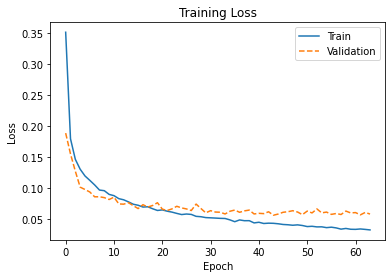

In [ ]:
plot_loss(model_history)

In [ ]:
import pickle
with open(BASEPATH+'model_historyM1_ab2.history', 'wb') as f:
  pickle.dump(model_history.history, f)


In [ ]:
a =model_history.history
min(a['val_loss']), a['val_loss'].index(min(a['val_loss']))

(0.05678131431341171, 43)

# Loading Model and results

In [10]:
loaded_model = tf.keras.models.load_model(BASEPATH+'checkpoint/keras.modelM1_ab2')
loaded_model.name

'multi_head_attention_classifier'

In [11]:
loaded_model.summary()

Model: "multi_head_attention_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (EmbeddingLa multiple                  1664      
_________________________________________________________________
multi_head_attention (MultiH multiple                  16384     
_________________________________________________________________
multi_head_attention_1 (Mult multiple                  0         
_________________________________________________________________
multi_head_attention_2 (Mult multiple                  0         
_________________________________________________________________
multi_head_attention_3 (Mult multiple                  0         
_________________________________________________________________
multi_head_attention_4 (Mult multiple                  0         
_________________________________________________________________
layer_normalization (LayerNo multip

In [12]:
%%time
y_pred_prob = loaded_model.predict(x_test)

CPU times: user 3.31 s, sys: 634 ms, total: 3.94 s
Wall time: 3.18 s


In [13]:
3.51/21008*1000

0.16707920792079206

In [14]:
y_pred = integerMapping(list(y_pred_prob.argmax(axis=-1)), intMapDict, inverse=True)
y_true = y_test

Precision or Positive Predictive Value (PPV):  TP/(TP+FP)

Sensitivity or Recall: TP/(TP+FN)

Specificity: TN/(TN+FP)

Accuracy (ACC): (TP+TN)/(TP+TN+FP+FN)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           /     0.9986    0.9986    0.9986       724
           A     0.9219    0.8585    0.8891       509
           E     1.0000    1.0000    1.0000        21
           F     0.9113    0.7063    0.7958       160
           J     0.9333    0.8235    0.8750        17
           L     0.9888    0.9888    0.9888      1614
           N     0.9880    0.9944    0.9912     14952
           Q     0.0000    0.0000    0.0000         3
           R     0.9972    0.9924    0.9948      1451
           S     0.0000    0.0000    0.0000         1
           V     0.9627    0.9607    0.9617      1425
           a     0.8800    0.7333    0.8000        30
           e     0.7500    1.0000    0.8571         3
           f     1.0000    0.9423    0.9703        52
           j     0.6512    0.6087    0.6292        46

    accuracy                         0.9846     21008
   macro avg     0.7989    0.7738    0.7835     21008
weighted avg     0.9841   

/content/drive/MyDrive/ecARR/report.py:54: RuntimeWarning: invalid value encountered in true_divide
  PPV = TP/(TP+FP)*100 # Precision, positive predictive value (PPV)


              precision    recall  f1-score   support

           F     0.9113    0.7063    0.7958       160
           N     0.9913    0.9961    0.9937     18066
           Q     1.0000    0.9923    0.9961       779
           S     0.9241    0.8528    0.8870       557
           V     0.9633    0.9613    0.9623      1446

    accuracy                         0.9876     21008
   macro avg     0.9580    0.9017    0.9270     21008
weighted avg     0.9873    0.9876    0.9873     21008



,Class,(PPV)Precision,(Sensitivity)Recall,Specificity,F1
0,F,91.13,70.62,99.95,79.58
1,N,99.13,99.61,94.63,99.37
2,Q,100.00,99.23,100.00,99.61
3,S,92.41,85.28,99.81,88.70
4,V,96.33,96.13,99.73,96.23


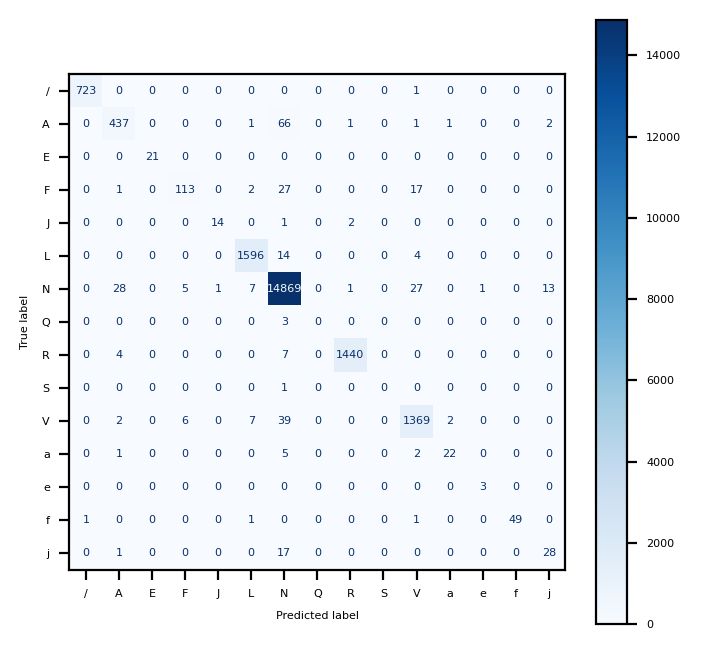

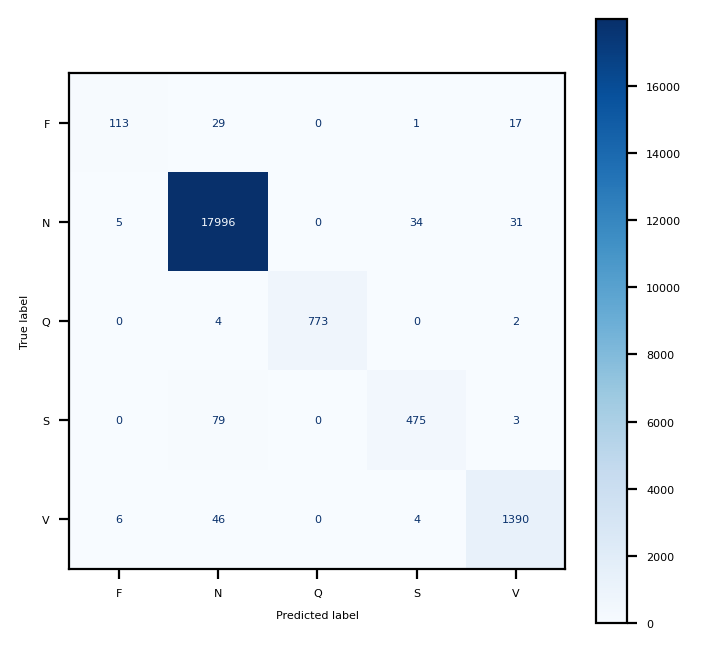

In [15]:
labels = [k for k,v in intMapDict.items()]
report = Reports(yTrue=y_true, yPred=y_pred, labels=labels)
normalize = None
report.plotConfusionMatrix(normalize=normalize, values_format='')
print(report.classificationReport())
report.metricsTable()


y_pred_AAMI = mappingAAMI(y_pred, MAP_AAMI)
y_true_AAMI = mappingAAMI(y_true, MAP_AAMI)
labels_AAMI = ['N','V','S','F','Q']
report = Reports(yTrue=y_true_AAMI, yPred=y_pred_AAMI, labels=labels_AAMI)
report.plotConfusionMatrix(normalize=normalize, values_format='')
print(report.classificationReport())
report.metricsTable()


In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true,y_pred),accuracy_score(y_true_AAMI,y_pred_AAMI)

(0.9845773038842346, 0.9875761614623001)

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
import matplotlib.pylab as pylab
import pandas as pd
import numpy as np

class Reports:
  '''
  Generate reports for the model
  '''
  def __init__(self, yTrue, yPred, labels=None):
    self.yTrue = yTrue
    self.yPred = yPred
    self.labels = labels
  
  def confusionMatrix(self, normalize=None):
    return confusion_matrix(self.yTrue, self.yPred, normalize=normalize)



  def plotConfusionMatrix(self, normalize=None, cmap='Blues', values_format='.2%'):
    #print(pylab.rcParams)
    params = {'legend.fontsize': 4,
              'figure.figsize': (4, 4),
              'axes.labelsize': 4,
              'axes.titlesize': 4,
              'xtick.labelsize': 4,
              'ytick.labelsize': 4,
              'font.size': 4.0,
              'figure.dpi': 200,
              'legend.frameon': False}
    #pylab.rcParams.update(params)
    if not self.labels: 
      print('Labels are not provided!')
    cm = self.confusionMatrix(normalize=normalize)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=sorted(self.labels))
    disp.plot(include_values=True, cmap=cmap, values_format=values_format)



  def classificationReport(self, digits=4):
    report=classification_report(self.yTrue, self.yPred, digits=digits)
    return report

  def metrics(self):
    #arrays with length equal to num classes
    cfm = self.confusionMatrix()
    FP = cfm.sum(axis=0) - np.diag(cfm) 
    FN = cfm.sum(axis=1) - np.diag(cfm)
    TP = np.diag(cfm)
    TN = cfm.sum() - (FP + FN + TP)

    TPR = TP/(TP+FN)*100 # Sensitivity, recall
    TNR = TN/(TN+FP)*100 # Specificity, true negative rate
    PPV = TP/(TP+FP)*100 # Precision, positive predictive value (PPV)
    NPV = TN/(TN+FN)*100  # Negative predictive value
    FPR = FP/(FP+TN)*100  # False positive rate
    FNR = FN/(TP+FN)*100  # False negative rate
    ACC = (TP+TN)/(TP+FP+FN+TN)*100  # Accuracy of each class
    F1=2*(PPV*TPR)/(PPV+TPR)
    out = {'Class':sorted(self.labels),'(PPV)Precision':PPV,'(Sensitivity)Recall':TPR,'Specificity':TNR,'F1':F1}
    return out

  def metricsTable(self):
    mt = self.metrics()
    df = pd.DataFrame(mt).round(2)
    return df
  
  def metricsArray(self):
    mt = self.metrics()
    df = pd.DataFrame(mt).round(2)
    return df.to_numpy()

  def accuracy(self):
    return round(accuracy_score(self.yTrue, self.yPred)*100,2)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in true_divide


              precision    recall  f1-score   support

           /     0.9986    0.9986    0.9986       724
           A     0.9219    0.8585    0.8891       509
           E     1.0000    1.0000    1.0000        21
           F     0.9113    0.7063    0.7958       160
           J     0.9333    0.8235    0.8750        17
           L     0.9888    0.9888    0.9888      1614
           N     0.9880    0.9944    0.9912     14952
           Q     0.0000    0.0000    0.0000         3
           R     0.9972    0.9924    0.9948      1451
           S     0.0000    0.0000    0.0000         1
           V     0.9627    0.9607    0.9617      1425
           a     0.8800    0.7333    0.8000        30
           e     0.7500    1.0000    0.8571         3
           f     1.0000    0.9423    0.9703        52
           j     0.6512    0.6087    0.6292        46

    accuracy                         0.9846     21008
   macro avg     0.7989    0.7738    0.7835     21008
weighted avg     0.9841   

,Class,(PPV)Precision,(Sensitivity)Recall,Specificity,F1
0,F,91.13,70.62,99.95,79.58
1,N,99.13,99.61,94.63,99.37
2,Q,100.00,99.23,100.00,99.61
3,S,92.41,85.28,99.81,88.70
4,V,96.33,96.13,99.73,96.23


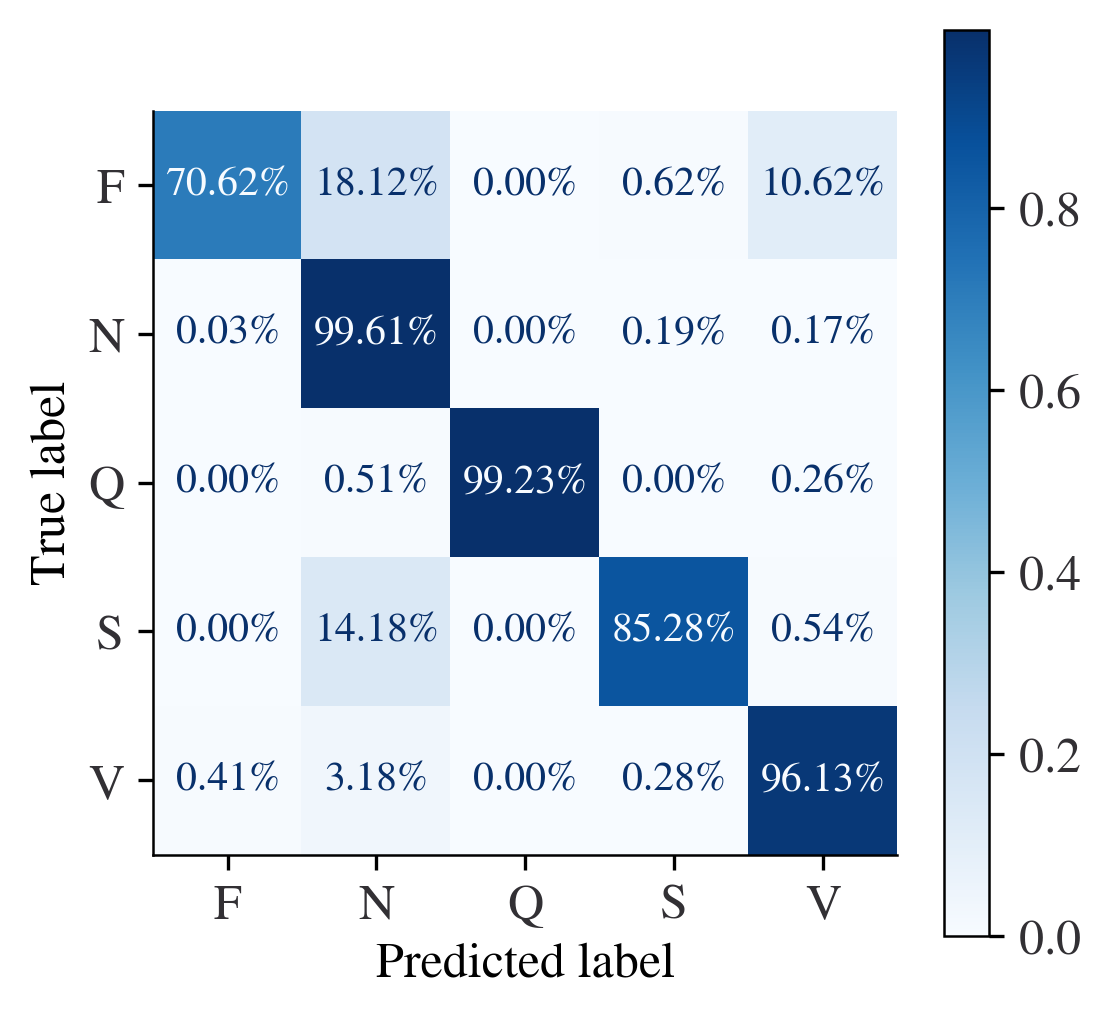

In [17]:
import matplotlib.pyplot as plt
plt.style.use('/content/drive/MyDrive/ecARR/plotstyle.txt')

labels = [k for k,v in intMapDict.items()]
report = Reports(yTrue=y_true, yPred=y_pred, labels=labels)
normalize = 'true'
#report.plotConfusionMatrix(normalize=normalize, values_format='')
print(report.classificationReport())
report.metricsTable()


y_pred_AAMI = mappingAAMI(y_pred, MAP_AAMI)
y_true_AAMI = mappingAAMI(y_true, MAP_AAMI)
labels_AAMI = ['N','V','S','F','Q']
report = Reports(yTrue=y_true_AAMI, yPred=y_pred_AAMI, labels=labels_AAMI)
report.plotConfusionMatrix(normalize=normalize, values_format='.2%')
print(report.classificationReport())
report.metricsTable()


In [ ]:
from sklearn.metrics import confusion_matrix
np.set_printoptions(suppress=True, formatter={'float_kind':'{:.2f}'.format})
cfm=confusion_matrix(y_true_AAMI, y_pred_AAMI, labels=sorted(labels_AAMI),normalize='true')*100
cfm
import pandas as pd
pd.DataFrame(cfm).round(2)

,0,1,2,3,4
0,70.62,18.12,0.00,0.62,10.62
1,0.03,99.61,0.00,0.19,0.17
2,0.00,0.51,99.23,0.00,0.26
3,0.00,14.18,0.00,85.28,0.54
4,0.41,3.18,0.00,0.28,96.13
